In [1]:
import pickle
import copy
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import pandas as pd
import sqlite3
from astropy.time import Time, TimeDelta
import astropy.units as u
from rubin_sim.scheduler.utils import restore_scheduler
from rubin_sim.scheduler.model_observatory import ModelObservatory
from rubin_sim.site_models import ScheduledDowntimeData
from rubin_sim.scheduler.schedulers import  SimpleFilterSched, FilterSchedUzy
from rubin_sim.scheduler.utils import SchemaConverter
from rubin_sim.utils import _approx_alt_az2_ra_dec
import rubin_sim.maf as maf

#from draft2_updated_uzy import main
from draft2_uzy_named import main

In [2]:
# Look at the full survey simulation pointing history
# (for now, just to look at number of observations and what night that corresponds to)

fname = '/Users/lynnej/lsst_repos/sims_featureScheduler_runs3.0/draft2_updated/draft2_updated_uzy_v2.99_10yrs.db'
conn = sqlite3.connect(fname)
allobs = pd.read_sql('select * from observations where night=180', conn)
conn.close()

In [3]:
# night 180 starts at visit 119522, contains about 940 visits
obs_start = allobs.observationId.iloc[0]
print(obs_start, len(allobs))
allobs
allobs[['observationStartMJD', 'fieldRA', 'fieldDec', 'rotSkyPos', 'filter', 
        'fiveSigmaDepth', 'seeingFwhmEff', 'note']][0:20]

119522 948


,observationStartMJD,fieldRA,fieldDec,rotSkyPos,filter,fiveSigmaDepth,seeingFwhmEff,note
0,60397.984596,66.071650,-6.517403,296.850041,r,23.058665,0.996971,twilight_neo
1,60397.984837,64.743020,-3.583116,295.667280,r,22.961317,1.038663,twilight_neo
2,60397.985078,63.249352,-0.744016,294.606480,r,22.853875,1.081522,twilight_neo
3,60397.985324,64.563511,6.751815,290.100224,r,22.725197,1.148625,twilight_neo
4,60397.985560,66.063292,9.132044,288.226442,r,22.695327,1.160610,twilight_neo
5,60397.985801,64.422546,11.810930,288.117446,r,22.515210,1.227192,twilight_neo
6,60397.986042,69.163734,13.874291,284.430535,r,22.663834,1.190123,twilight_neo
7,60397.986277,67.595174,11.508058,286.442631,r,22.735390,1.176810,twilight_neo
8,60397.986521,67.663145,6.419552,288.762512,r,22.914816,1.109781,twilight_neo
9,60397.986757,66.170522,4.034366,290.857266,r,22.935512,1.102050,twilight_neo


In [4]:
class survey_args(object):
    def __init__(self, verbose=True, survey_length=365.25*10,
                outDir="", dbroot=None, maxDither=0.7,moon_illum_limit=40.,
                nexp=2,rolling_nslice=2,rolling_strength=0.9, gsw=3.0,
                ddf_season_frac=0.2, nights_off=6, nights_delayed=-1,
                neo_night_pattern=4, neo_filters='riz', neo_repeat=4):
        self.verbose = verbose
        self.survey_length=survey_length
        self.outDir=outDir
        self.dbroot=dbroot
        self.maxDither=maxDither
        self.moon_illum_limit=moon_illum_limit
        self.nexp=nexp
        self.rolling_nslice=rolling_nslice
        self.rolling_strength=rolling_strength
        self.gsw=gsw
        self.ddf_season_frac=ddf_season_frac
        self.nights_off=nights_off
        self.nights_delayed=nights_delayed
        self.neo_night_pattern=neo_night_pattern
        self.neo_filters=neo_filters
        self.neo_repeat=neo_repeat

# Set survey length to 0 here, so that we don't run scheduler yet
args = survey_args(survey_length=0.)  

In [5]:
# Set up scheduler -- convenience method from draft2_uzy_named here, as "main" imports a script 
# which sets up the scheduler (surveys + some camera information) and model observatory (mock telemetry)
# observations is blank because we chose a 0 survey_length above

observatory, scheduler, observations = main(args)

Optimizing ELAISS1
Optimizing XMM_LSS
Optimizing ECDFS
Optimizing COSMOS
Optimizing EDFS_a
Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 0 observations
ran in 0 min = 0.0 hours


In [6]:
# What is the "scheduler" -- tiers of 'surveys' plus some extra information (camera/rotator limits)
scheduler

/Users/lynnej/anaconda3/envs/rubin/lib/python3.11/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)
/Users/lynnej/anaconda3/envs/rubin/lib/python3.11/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


# CoreScheduler at 0x1a245d8d0
|                | value                   |
|:---------------|:------------------------|
| camera         | LSST                    |
| nside          | 32                      |
| rotator limits | [1.48352986 4.79965544] |
| survey index   | [None, None]            |
| Last chosen    | None                    |

## Surveys

### Survey list 0
| survey                                         | reward   | chosen   |
|:-----------------------------------------------|:---------|:---------|
| <ScriptedSurvey survey_name='' at 0x1a3e8b010> |          | False    |
| <ScriptedSurvey survey_name='' at 0x1a3e8bf10> |          | False    |

### Survey list 1
| survey                                                                        | reward   | chosen   |
|:------------------------------------------------------------------------------|:---------|:---------|
| <LongGapSurvey survey_name='Long Gap (Pair blob g_r + third)' at 0x1a1916350> |          | False    |
| <LongGapSurvey survey_name='Long Gap (Pair blob r_i + third)' at 0x1a2022ad0> |          | False    |
| <LongGapSurvey survey_name='Long Gap (Pair blob i_z + third)' at 0x1a2044e10> |          | False    |

### Survey list 2
| survey                                                            | reward   | chosen   |
|:------------------------------------------------------------------|:---------|:---------|
| <BlobSurvey survey_name='Standard pair blobs u_g' at 0x1a20446d0> |          | False    |
| <BlobSurvey survey_name='Standard pair blobs u_r' at 0x1a201a890> |          | False    |
| <BlobSurvey survey_name='Standard pair blobs g_r' at 0x1a2005b50> |          | False    |
| <BlobSurvey survey_name='Standard pair blobs r_i' at 0x1a28bcb90> |          | False    |
| <BlobSurvey survey_name='Standard pair blobs i_z' at 0x1b04bd290> |          | False    |
| <BlobSurvey survey_name='Standard pair blobs z_y' at 0x1a2004f90> |          | False    |
| <BlobSurvey survey_name='Standard pair blobs y_y' at 0x1a20505d0> |          | False    |

### Survey list 3
| survey                                                           | reward   | chosen   |
|:-----------------------------------------------------------------|:---------|:---------|
| <BlobSurvey survey_name='Twilight pair blob r_i' at 0x1a3e96550> |          | False    |
| <BlobSurvey survey_name='Twilight pair blob i_z' at 0x1a35af710> |          | False    |
| <BlobSurvey survey_name='Twilight pair blob z_y' at 0x1b04bf590> |          | False    |
| <BlobSurvey survey_name='Twilight pair blob y_y' at 0x1a35afb90> |          | False    |

### Survey list 4
| survey                                                               | reward   | chosen   |
|:---------------------------------------------------------------------|:---------|:---------|
| <BlobSurvey survey_name='Near Sun twilight survey r' at 0x19fda39d0> |          | False    |
| <BlobSurvey survey_name='Near Sun twilight survey i' at 0x1a28bfe50> |          | False    |
| <BlobSurvey survey_name='Near Sun twilight survey z' at 0x1a1ff2a10> |          | False    |

### Survey list 5
| survey                                                               | reward   | chosen   |
|:---------------------------------------------------------------------|:---------|:---------|
| <GreedySurvey survey_name='Twilight greedy survey r' at 0x1a21f0210> |          | False    |
| <GreedySurvey survey_name='Twilight greedy survey i' at 0x1a3e62810> |          | False    |
| <GreedySurvey survey_name='Twilight greedy survey z' at 0x1a3e58a50> |          | False    |
| <GreedySurvey survey_name='Twilight greedy survey y' at 0x1a1ff1910> |          | False    |

No conditions set

## Queue
Queue is empty


In [7]:
# The "model observatory" simulates the telescope and observatory and telemetry 
conditions = observatory.return_conditions()

print(observatory.mjd)
conditions

60218.0


Conditions at 0x1a3e73f50
============================
nside:  32   
site:  LSST   
exptime:  30.0   
lmst:  19.914910499544927   
season_offset:  [-586.79196505 -678.10446505 -404.16696505 ... -678.10446505 -404.16696505
 -495.47946505]   
sun_RA_start:  [3.25752469]   
clouds:  None   
current_filter:  r   
mounted_filters:  ['u', 'g', 'r', 'i', 'y']   
night:  0   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  None   
moonPhase:  87.42165280354018   
bulk_cloud:  0.0   
targets_of_opportunity:  None   
season_modulo:  None   
season_max_season:  None   
season_length:  365.25   
season_floor:  True   
cumulative_azimuth_rad:  0   

Positions (radians)
-------------------
| name      |         alt |       az |         RA |        decl |   rot |
|:----------|------------:|---------:|-----------:|------------:|------:|
| sun       |  -0.298101  | nan      |   3.25752  |  -0.0500932 |   nan |
| moon      |  -0.0932824 |   1.3813 |   0.481462 |   0.20844   |   nan |
| venus     | nan         | nan      |   0.627558 |   0.209499  |   nan |
| mars      | nan         | nan      |   3.6558   |  -0.199382  |   nan |
| jupiter   | nan         | nan      |   0.615007 |   0.223621  |   nan |
| saturn    | nan         | nan      |   5.8825   |  -0.198137  |   nan |
| telescope |   1.50971   |   0      | nan        | nan         |     0 |

Positions (degrees)
-------------------
| name      |       alt |       az |       RA |      decl |   rot |
|:----------|----------:|---------:|---------:|----------:|------:|
| sun       | -17.0799  | nan      | 186.642  |  -2.87013 |   nan |
| moon      |  -5.34469 |  79.1425 |  27.5857 |  11.9427  |   nan |
| venus     | nan       | nan      |  35.9564 |  12.0034  |   nan |
| mars      | nan       | nan      | 209.462  | -11.4237  |   nan |
| jupiter   | nan       | nan      |  35.2373 |  12.8126  |   nan |
| saturn    | nan       | nan      | 337.042  | -11.3524  |   nan |
| telescope |  86.5     |   0      | nan      | nan       |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| sunset          | 60217.9 | 2023-09-30 22:39:51.673596160 |
| sun_n12_setting | 60218   | 2023-09-30 23:35:54.616369408 |
| mjd_start       | 60218   | 2023-10-01 00:00:00           |
| mjd             | 60218   | 2023-10-01 00:00:00           |
| sun_n18_setting | 60218   | 2023-10-01 00:04:24.336566528 |
| moonrise        | 60218   | 2023-10-01 00:26:34.435568128 |
| sun_n18_rising  | 60218.4 | 2023-10-01 09:00:53.238134016 |
| sun_n12_rising  | 60218.4 | 2023-10-01 09:29:21.885313792 |
| sunrise         | 60218.4 | 2023-10-01 10:25:22.012773120 |
| moonset         | 60218.5 | 2023-10-01 11:37:31.451933440 |

Maps
----
| map             |   nside |       min |       max |    median |
|:----------------|--------:|----------:|----------:|----------:|
| airmass         |      32 |  1.00008  |  11.4722  |  1.83598  |
| slewtime        |      32 |  4.9848   | 155.977   | 94.9251   |
| dec             |      32 | -1.54528  |   1.54528 |  0        |
| ra              |      32 |  0        |   6.25864 |  3.12932  |
| m5_depth_u      |      32 | 22.5371   |  24.0962  | 23.6061   |
| m5_depth_g      |      32 | 23.4482   |  24.9333  | 24.551    |
| m5_depth_r      |      32 | 23.1573   |  24.5225  | 24.146    |
| m5_depth_i      |      32 | 22.7677   |  24.0299  | 23.6314   |
| m5_depth_z      |      32 | 22.283    |  23.435   | 23.0232   |
| m5_depth_y      |      32 | 21.3502   |  22.6019  | 22.1405   |
| fwhm_eff_u      |      32 |  0.81327  |   3.51562 |  1.17094  |
| fwhm_eff_g      |      32 |  0.771248 |   3.33397 |  1.11044  |
| fwhm_eff_r      |      32 |  0.734575 |   3.17544 |  1.05763  |
| fwhm_eff_i      |      32 |  0.710171 |   3.06994 |  1.0225   |
| fwhm_eff_z      |      32 |  0.693292 |   2.99697 |  0.998195 |
| fwhm_eff_y      |      32 |  0.680473 |   2.94156 |  0.979739 |
| skybrightness_u |      32 | 21.6503   |  22.5988  | 22.41     |
| skybrightness_g |      32 | 20.6325   |  22.1417  | 21.9002   |
| skybrightness_r |      32 | 19.8177   |  21.2386  | 20.9737   |
| skybrightness_i |      32 | 19.1418   |  20.3644  | 20.0688   |
| skybrightness_z |      32 | 18.4045   |  19.4444  | 19.1216   |
| skybrightness_y |      32 | 17.6764   |  18.6061  | 18.2768   |


In [8]:
%%time
# Kind of painful and slow. 
# Telescope currently uses pickles, but we need to improve serialization methods.

scheduler, observatory = restore_scheduler(obs_start, scheduler, observatory, fname)

CPU times: user 15min 5s, sys: 7.14 s, total: 15min 12s
Wall time: 15min 16s


In [9]:
# Observatory might not be in the right state for the lunar cycle ... 

filter_scheduler = FilterSchedUzy(illum_limit=40)
filters_needed = filter_scheduler(conditions)
observatory.observatory.mount_filters(filters_needed)

conditions = observatory.return_conditions()
print(observatory.mjd)
conditions

60397.984781278385


Conditions at 0x1a3e73f50
============================
nside:  32   
site:  LSST   
exptime:  30.0   
lmst:  7.376429592453547   
season_offset:  [-586.79196505 -678.10446505 -404.16696505 ... -678.10446505 -404.16696505
 -495.47946505]   
sun_RA_start:  [3.25752469]   
clouds:  None   
current_filter:  r   
mounted_filters:  ['g', 'r', 'i', 'z', 'y']   
night:  180   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  None   
moonPhase:  77.01804572161613   
bulk_cloud:  0.0   
targets_of_opportunity:  None   
season_modulo:  None   
season_max_season:  None   
season_length:  365.25   
season_floor:  True   
cumulative_azimuth_rad:  0   

Positions (radians)
-------------------
| name      |        alt |        az |         RA |        decl |   rot |
|:----------|-----------:|----------:|-----------:|------------:|------:|
| sun       |  -0.220494 | nan       |   0.135265 |   0.0583825 |   nan |
| moon      |  -0.190112 |   2.11023 |   3.95609  |  -0.346006  |   nan |
| venus     | nan        | nan       |   5.74204  |  -0.278839  |   nan |
| mars      | nan        | nan       |   5.46746  |  -0.338838  |   nan |
| jupiter   | nan        | nan       |   0.895951 |   0.309223  |   nan |
| saturn    | nan        | nan       |   5.97874  |  -0.163438  |   nan |
| telescope |   1.50971  |   0       | nan        | nan         |     0 |

Positions (degrees)
-------------------
| name      |      alt |      az |        RA |      decl |   rot |
|:----------|---------:|--------:|----------:|----------:|------:|
| sun       | -12.6334 | nan     |   7.75014 |   3.34507 |   nan |
| moon      | -10.8926 | 120.907 | 226.667   | -19.8247  |   nan |
| venus     | nan      | nan     | 328.994   | -15.9763  |   nan |
| mars      | nan      | nan     | 313.263   | -19.414   |   nan |
| jupiter   | nan      | nan     |  51.3342  |  17.7172  |   nan |
| saturn    | nan      | nan     | 342.556   |  -9.36432 |   nan |
| telescope |  86.5    |   0     | nan       | nan       |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| mjd_start       | 60218   | 2023-10-01 00:00:00           |
| sunset          | 60397.9 | 2024-03-28 22:39:39.850686976 |
| sun_n12_setting | 60398   | 2024-03-28 23:35:13.102452480 |
| mjd             | 60398   | 2024-03-28 23:38:05.102444800 |
| sun_n18_setting | 60398   | 2024-03-29 00:03:04.845788672 |
| moonrise        | 60398   | 2024-03-29 00:36:14.798543872 |
| sun_n18_rising  | 60398.4 | 2024-03-29 09:32:39.568771840 |
| sun_n12_rising  | 60398.4 | 2024-03-29 10:00:32.861164288 |
| sunrise         | 60398.5 | 2024-03-29 10:56:10.579571968 |
| moonset         | 60398.6 | 2024-03-29 14:42:13.952231680 |

Maps
----
| map             |   nside |       min |       max |   median |
|:----------------|--------:|----------:|----------:|---------:|
| airmass         |      32 |  1.00003  |  11.4707  |  1.8426  |
| slewtime        |      32 |  4.56171  | 155.98    | 94.7948  |
| dec             |      32 | -1.54528  |   1.54528 |  0       |
| ra              |      32 |  0        |   6.25864 |  3.12932 |
| m5_depth_u      |      32 | 20.955    |  23.0959  | 22.485   |
| m5_depth_g      |      32 | 22.4068   |  24.148   | 23.6477  |
| m5_depth_r      |      32 | 22.5112   |  24.0851  | 23.6184  |
| m5_depth_i      |      32 | 21.9497   |  23.4924  | 23.0331  |
| m5_depth_z      |      32 | 21.3728   |  22.8522  | 22.4059  |
| m5_depth_y      |      32 | 20.2777   |  21.9167  | 21.428   |
| fwhm_eff_u      |      32 |  0.879664 |   3.80243 |  1.26931 |
| fwhm_eff_g      |      32 |  0.830964 |   3.59192 |  1.19904 |
| fwhm_eff_r      |      32 |  0.788294 |   3.40748 |  1.13747 |
| fwhm_eff_i      |      32 |  0.759799 |   3.28431 |  1.09635 |
| fwhm_eff_z      |      32 |  0.740037 |   3.19888 |  1.06784 |
| fwhm_eff_y      |      32 |  0.724999 |   3.13388 |  1.04614 |
| skybrightness_u |      32 | 18.3783   |  20.2479  | 19.8914  |
| skybrightness_g |      32 | 18.6809   |  20.5014  | 20.1278  |
| skybrightness_r |      32 | 18.6662   |  20.3973  | 20.0113  |
| skybrightness_i |      32 | 17.6426   |  19.372   | 18.988   |
| skybrightness_z |      32 | 16.7189   |  18.387   | 18.0028  |
| skybrightness_y |      32 | 15.6359   |  17.3457  | 16.966   |


In [10]:
# Save, if we want to pick up again later 
with open('schedn.pickle', 'wb') as file:
    pickle.dump(scheduler, file)
with open('observatory.pickle', 'wb') as file:
    pickle.dump(observatory, file)

In [11]:
# Read from disk, if we didn't need to rerun above
with open('schedn.pickle', 'rb') as file:
    scheduler = pickle.load(file)
with open('observatory.pickle', 'rb') as file:
    observatory = pickle.load(file)

In [12]:
# What telemetry do we have now? 

conditions=observatory.return_conditions()
# When is this? 
print(Time(conditions.mjd, format='mjd').isot)

conditions

2024-03-28T23:38:05.102


Conditions at 0x1a1972110
============================
nside:  32   
site:  LSST   
exptime:  30.0   
lmst:  7.376429592453547   
season_offset:  [-586.79196505 -678.10446505 -404.16696505 ... -678.10446505 -404.16696505
 -495.47946505]   
sun_RA_start:  [3.25752469]   
clouds:  None   
current_filter:  r   
mounted_filters:  ['g', 'r', 'i', 'z', 'y']   
night:  180   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  None   
moonPhase:  77.01804572161613   
bulk_cloud:  0.0   
targets_of_opportunity:  None   
season_modulo:  None   
season_max_season:  None   
season_length:  365.25   
season_floor:  True   
cumulative_azimuth_rad:  0   

Positions (radians)
-------------------
| name      |        alt |        az |         RA |        decl |   rot |
|:----------|-----------:|----------:|-----------:|------------:|------:|
| sun       |  -0.220494 | nan       |   0.135265 |   0.0583825 |   nan |
| moon      |  -0.190112 |   2.11023 |   3.95609  |  -0.346006  |   nan |
| venus     | nan        | nan       |   5.74204  |  -0.278839  |   nan |
| mars      | nan        | nan       |   5.46746  |  -0.338838  |   nan |
| jupiter   | nan        | nan       |   0.895951 |   0.309223  |   nan |
| saturn    | nan        | nan       |   5.97874  |  -0.163438  |   nan |
| telescope |   1.50971  |   0       | nan        | nan         |     0 |

Positions (degrees)
-------------------
| name      |      alt |      az |        RA |      decl |   rot |
|:----------|---------:|--------:|----------:|----------:|------:|
| sun       | -12.6334 | nan     |   7.75014 |   3.34507 |   nan |
| moon      | -10.8926 | 120.907 | 226.667   | -19.8247  |   nan |
| venus     | nan      | nan     | 328.994   | -15.9763  |   nan |
| mars      | nan      | nan     | 313.263   | -19.414   |   nan |
| jupiter   | nan      | nan     |  51.3342  |  17.7172  |   nan |
| saturn    | nan      | nan     | 342.556   |  -9.36432 |   nan |
| telescope |  86.5    |   0     | nan       | nan       |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| mjd_start       | 60218   | 2023-10-01 00:00:00           |
| sunset          | 60397.9 | 2024-03-28 22:39:39.850686976 |
| sun_n12_setting | 60398   | 2024-03-28 23:35:13.102452480 |
| mjd             | 60398   | 2024-03-28 23:38:05.102444800 |
| sun_n18_setting | 60398   | 2024-03-29 00:03:04.845788672 |
| moonrise        | 60398   | 2024-03-29 00:36:14.798543872 |
| sun_n18_rising  | 60398.4 | 2024-03-29 09:32:39.568771840 |
| sun_n12_rising  | 60398.4 | 2024-03-29 10:00:32.861164288 |
| sunrise         | 60398.5 | 2024-03-29 10:56:10.579571968 |
| moonset         | 60398.6 | 2024-03-29 14:42:13.952231680 |

Maps
----
| map             |   nside |       min |       max |   median |
|:----------------|--------:|----------:|----------:|---------:|
| airmass         |      32 |  1.00003  |  11.4707  |  1.8426  |
| slewtime        |      32 |  4.56171  | 155.98    | 94.7948  |
| dec             |      32 | -1.54528  |   1.54528 |  0       |
| ra              |      32 |  0        |   6.25864 |  3.12932 |
| m5_depth_u      |      32 | 20.955    |  23.0959  | 22.485   |
| m5_depth_g      |      32 | 22.4068   |  24.148   | 23.6477  |
| m5_depth_r      |      32 | 22.5112   |  24.0851  | 23.6184  |
| m5_depth_i      |      32 | 21.9497   |  23.4924  | 23.0331  |
| m5_depth_z      |      32 | 21.3728   |  22.8522  | 22.4059  |
| m5_depth_y      |      32 | 20.2777   |  21.9167  | 21.428   |
| fwhm_eff_u      |      32 |  0.879664 |   3.80243 |  1.26931 |
| fwhm_eff_g      |      32 |  0.830964 |   3.59192 |  1.19904 |
| fwhm_eff_r      |      32 |  0.788294 |   3.40748 |  1.13747 |
| fwhm_eff_i      |      32 |  0.759799 |   3.28431 |  1.09635 |
| fwhm_eff_z      |      32 |  0.740037 |   3.19888 |  1.06784 |
| fwhm_eff_y      |      32 |  0.724999 |   3.13388 |  1.04614 |
| skybrightness_u |      32 | 18.3783   |  20.2479  | 19.8914  |
| skybrightness_g |      32 | 18.6809   |  20.5014  | 20.1278  |
| skybrightness_r |      32 | 18.6662   |  20.3973  | 20.0113  |
| skybrightness_i |      32 | 17.6426   |  19.372   | 18.988   |
| skybrightness_z |      32 | 16.7189   |  18.387   | 18.0028  |
| skybrightness_y |      32 | 15.6359   |  17.3457  | 16.966   |


Standard pair blobs r_i
odict_keys(['u_sky', 'g_sky', 'r_sky', 'i_sky', 'z_sky', 'y_sky', 'M5DiffBasisFunction r @10536806480', 'M5DiffBasisFunction i @10536806800', 'FootprintBasisFunction r @10536807696', 'FootprintBasisFunction i @10536809232', 'SlewtimeBasisFunction r @10536811024', 'VisitRepeatBasisFunction @10536810384', 'NObsPerYearBasisFunction r @7022704208', 'NObsPerYearBasisFunction i @7022705872', 'NGoodSeeingBasisFunction r @7022701840', 'NGoodSeeingBasisFunction i @7022696272', 'ZenithShadowMaskBasisFunction @7022693328', 'MoonAvoidanceBasisFunction @7022694928', 'PlanetMaskBasisFunction @7015745552'])


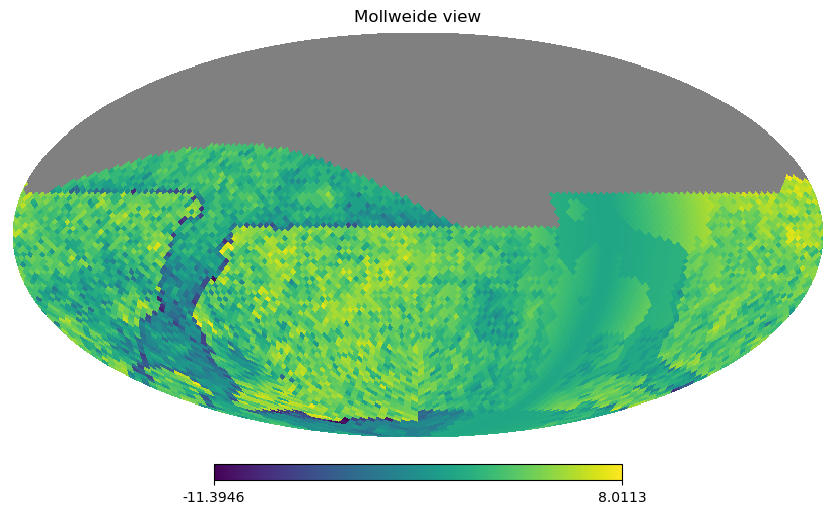

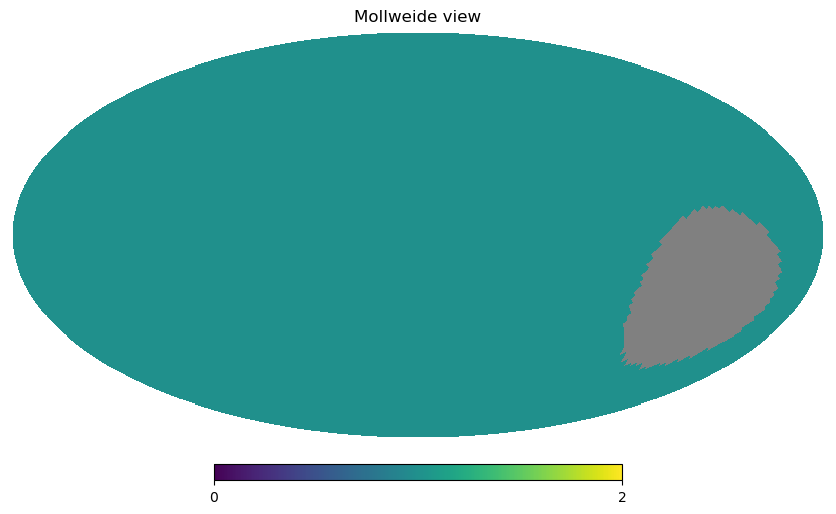

In [13]:
# Can peek into scheduler and look at progress/status for individual surveys 
# -- "schedview" for on-the-fly monitoring

tier = 2
idx = 3
check_survey = scheduler.survey_lists[tier][idx]
print(check_survey.survey_name)

maps = scheduler.get_healpix_maps([tier, idx], conditions)
print(maps.keys())
r_footprint = [k for k in maps.keys() if "Footprint" in k and "r @" in k][0]
hp.mollview(maps[r_footprint])
moon_map = [k for k in maps.keys() if k.startswith('MoonAvoidance')][0]
hp.mollview(maps[moon_map])

In [14]:
def make_observations(scheduler, observatory, desired_observations=1000):
    
    # How /when to mount or unmount the filters
    #filter_scheduler = SimpleFilterSched()
    filter_scheduler = FilterSchedUzy(illum_limit=40)

    observations = []
    # Time to skip ahead if there are no requested observations
    step_none = 5.0 / 60.0 / 24.0  # minutesto days 
    nskip = 0
    new_night = False
    mjd_last_flush = -1
    
    # Just try to take observations for 1 night or until we reach desired_observations desired
    while not new_night and (len(observations) <= desired_observations):
        # update conditions / times /skybrightness
        if not scheduler._check_queue_mjd_only(observatory.mjd):
            scheduler.update_conditions(observatory.return_conditions())
        # Look for observations from the scheduler
        desired_obs = scheduler.request_observation(mjd=observatory.mjd)
        if desired_obs is None:
            # No observation. Just step into the future and try again.
            warnings.warn("No observation. Step into the future and trying again.")
            observatory.mjd = observatory.mjd + step_none
            scheduler.update_conditions(observatory.return_conditions())
            nskip += 1
            continue
            
        # use the model observatory to "observe"
        completed_obs, new_night = observatory.observe(desired_obs)
        if completed_obs is not None:
            scheduler.add_observation(completed_obs[0])
            observations.append(completed_obs)
            filter_scheduler.add_observation(completed_obs[0])
        else:
            # An observation failed to execute, usually it was outside the altitude limits.
            if observatory.mjd == mjd_last_flush:
                raise RuntimeError(
                    "Scheduler has failed to provide a valid observation multiple times."
                )
            # if this is a first offence, might just be that targets set. 
            # Flush queue and get some new targets.
            scheduler.flush_queue()
            mjd_last_flush = observatory.mjd + 0
            
    print(f'{len(observations)} acquired')
        
    if new_night:
        # find out what filters we want mounted
        conditions = observatory.return_conditions()
        filters_needed = filter_scheduler(conditions)
        print(f'End of night: current filters {conditions.mounted_filters}')
        print(f'Required filters for next night: {filters_needed}')
        if not set(filters_needed) == set(conditions.mounted_filters):
            print(f'Need to swap some filters')
        # change the filters in the model observatory, for simulation purposes
        observatory.observatory.mount_filters(filters_needed)
             
    return scheduler, observatory, observations

In [15]:
new_scheduler = copy.deepcopy(scheduler)
new_observatory = copy.deepcopy(observatory)

new_scheduler, new_observatory, observations = make_observations(new_scheduler,
                                                                 new_observatory, 
                                                                 desired_observations=1000)

940 acquired
End of night: current filters ['g', 'r', 'i', 'z', 'y']
Required filters for next night: ['g', 'r', 'i', 'z', 'y']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/skybrightness_pre/sky_model_pre.py:272: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


In [16]:
# Transform 'observations' into the same format/degrees, etc. as simulation outputs
sc = SchemaConverter()

newobs = sc.obs2opsim(np.array(observations)[:, 0])

shortcols = ['observationStartMJD', 'fieldRA', 'fieldDec', 'rotSkyPos', 'filter', 'fiveSigmaDepth', 
             'seeingFwhmEff', 'night', 'note', 'sunAlt']
newobs[shortcols]

,observationStartMJD,fieldRA,fieldDec,rotSkyPos,filter,fiveSigmaDepth,seeingFwhmEff,night,note,sunAlt
0,60397.985735,66.071650,-6.517403,297.145317,r,23.127974,1.003672,180,twilight_neo,-12.928914
1,60397.985976,64.743020,-3.583116,295.840527,r,23.035618,1.043090,180,twilight_neo,-13.003421
2,60397.986217,63.249352,-0.744016,294.784514,r,22.929774,1.086595,180,twilight_neo,-13.078050
3,60397.986460,63.090652,4.371819,292.200137,r,22.803266,1.145481,180,twilight_neo,-13.153153
4,60397.986701,61.427819,7.036797,291.838367,r,22.635247,1.208415,180,twilight_neo,-13.227866
...,...,...,...,...,...,...,...,...,...,...
935,60398.415738,323.430877,-11.752217,181.238459,r,22.136194,1.401021,180,twilight_neo,-12.408490
936,60398.415976,322.560371,-14.789588,179.429658,r,22.216179,1.355159,180,twilight_neo,-12.334012
937,60398.416214,321.737014,-17.866448,177.348753,r,22.273191,1.316195,180,twilight_neo,-12.259671
938,60398.416469,321.350637,-9.829587,182.735483,r,22.147079,1.378770,180,twilight_neo,-12.179703


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


2

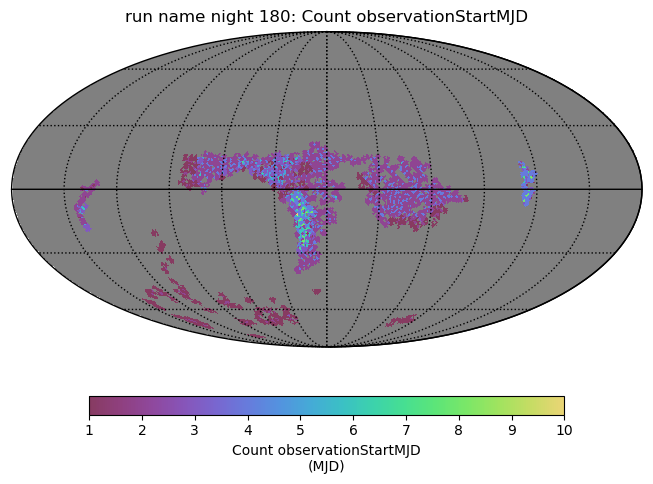

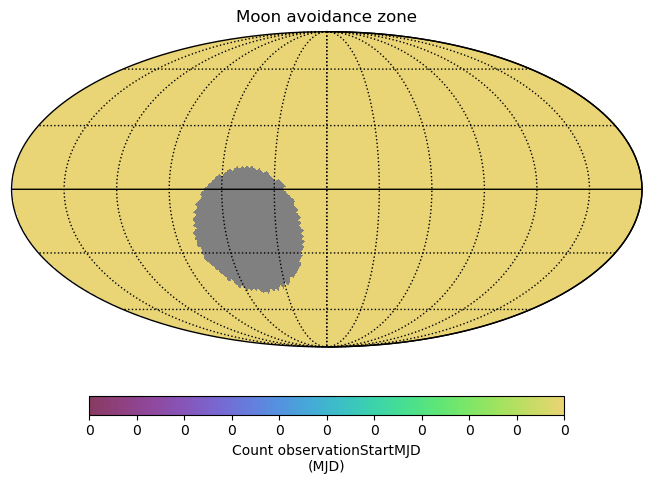

In [17]:
# we can feed that into a feature object to make a map - or feed it into MAF

metric = maf.CountMetric(col='observationStartMJD')
slicer = maf.HealpixSlicer(nside=64)
constraint = None
bundle = maf.MetricBundle(metric, slicer, constraint, info_label='night 180')

g = maf.MetricBundleGroup({'count': bundle}, None)
g.run_current(sim_data=newobs.to_records(), constraint=None)

ph = maf.PlotHandler()
ph.set_metric_bundles([bundle])
ph.plot(maf.HealpixSkyMap(), plot_dicts={'rot': (180, 0, 0)})
# for reference on moon location 
tmp = copy.deepcopy(bundle)
tmp.metric_values = np.ma.MaskedArray(data=maps[moon_map], mask=False)
ph.set_metric_bundles([tmp])
ph.plot(maf.HealpixSkyMap(), plot_dicts={'title': "Moon avoidance zone", 'rot': (180, 0, 0)})

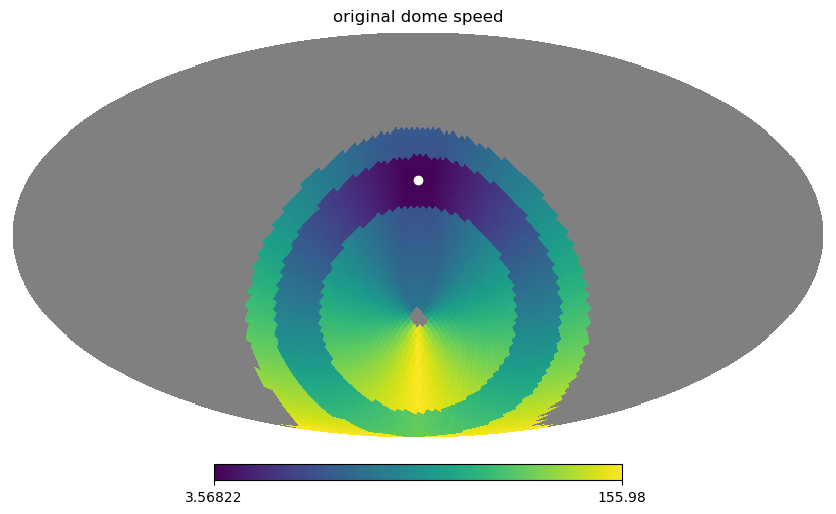

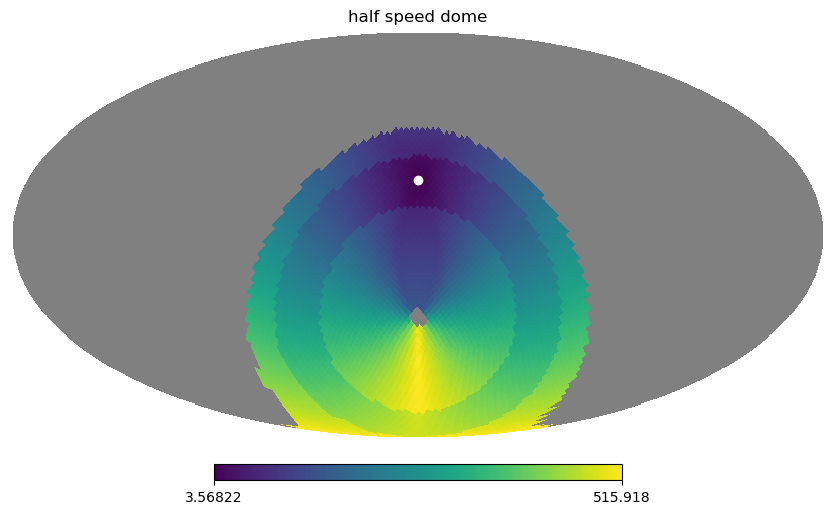

In [18]:
# could modify observatory with different telemetry stream, etc.
# or can modify survey strategy 
# Let's pretend dome motor speed is broken (moving slower) 

new_scheduler = copy.deepcopy(scheduler)
new_observatory = copy.deepcopy(observatory)

kinem_model = new_observatory.observatory
proper_park_alt = kinem_model.park_alt_rad
proper_park_az = kinem_model.park_az_rad
kinem_model.parked = True
kinem_model.park_alt_rad = np.radians(40)
kinem_model.park_az_rad = 0

conditions = new_observatory.return_conditions()
slewtimes = conditions.slewtime

jj = _approx_alt_az2_ra_dec([conditions.tel_alt], [conditions.tel_az], 
                       conditions.site.latitude_rad, conditions.site.longitude_rad,
                       conditions.mjd)
plot_tel_ra = np.degrees(jj[0][0])
plot_tel_dec = np.degrees(jj[1][0])

hp.mollview(slewtimes, title='original dome speed', rot=(conditions.lmst*360/24,0,0))
hp.projscatter(plot_tel_ra, plot_tel_dec, lonlat=True, c='white')

factor = 0.25
new_observatory.setup_dome(altitude_maxspeed=1.75*factor,
                            altitude_accel=0.875*factor,
                            altitude_decel=0.875*factor,
                            azimuth_maxspeed=1.5*factor,
                            azimuth_accel=0.75*factor,
                            azimuth_decel=0.75*factor,
                            settle_time=1.0,)

conditions = new_observatory.return_conditions()
slewtimes = conditions.slewtime

hp.mollview(slewtimes, title="half speed dome", rot=(conditions.lmst*360/24,0,0))
hp.projscatter(plot_tel_ra, plot_tel_dec, lonlat=True, c='white')

# repark
kinem_model.parked = True
kinem_model.park_alt_rad = proper_park_alt
kinem_model.park_az_rad = proper_park_az

In [19]:
### Now resimulate night, with slow speed dome
new_scheduler, new_observatory, slow_observations = make_observations(new_scheduler,
                                                                 new_observatory, 
                                                                 desired_observations=1000)

newobs = sc.obs2opsim(np.array(slow_observations)[:, 0])

shortcols = ['observationStartMJD', 'fieldRA', 'fieldDec', 'rotSkyPos', 'filter', 'fiveSigmaDepth', 
             'seeingFwhmEff', 'night', 'note', 'sunAlt']
newobs[shortcols]

774 acquired
End of night: current filters ['g', 'r', 'i', 'z', 'y']
Required filters for next night: ['g', 'r', 'i', 'z', 'y']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/skybrightness_pre/sky_model_pre.py:272: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


,observationStartMJD,fieldRA,fieldDec,rotSkyPos,filter,fiveSigmaDepth,seeingFwhmEff,night,note,sunAlt
0,60397.987171,66.228179,-1.158782,293.441489,i,22.596747,1.005294,180,twilight_neo,-13.373519
1,60397.987411,63.249352,-0.744016,294.968168,i,22.473533,1.052548,180,twilight_neo,-13.447774
2,60397.987647,64.702147,1.645974,293.030472,i,22.494955,1.059105,180,twilight_neo,-13.520842
3,60397.987887,61.639225,1.995307,294.269087,i,22.405165,1.104362,180,twilight_neo,-13.595092
4,60397.988123,63.090652,4.371819,292.490420,i,22.424307,1.079262,180,twilight_neo,-13.668048
...,...,...,...,...,...,...,...,...,...,...
769,60398.415753,316.974621,1.970107,190.491035,r,22.111788,1.450770,180,twilight_neo,-12.403592
770,60398.415989,319.012901,0.030143,188.772699,r,22.060486,1.460284,180,twilight_neo,-12.329865
771,60398.416225,321.060808,-1.905882,187.154164,r,22.019109,1.472331,180,twilight_neo,-12.256147
772,60398.416464,320.175826,-4.900252,185.869275,r,22.132030,1.413087,180,twilight_neo,-12.181334


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


1

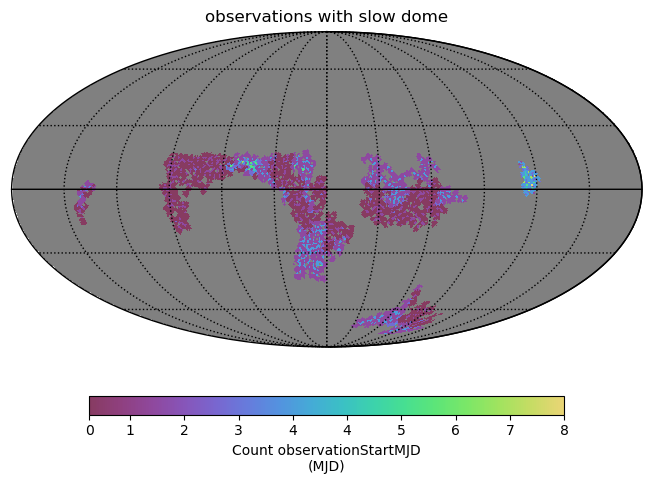

In [20]:
# we can feed that into a feature object to make a map - or feed it into MAF

metric = maf.CountMetric(col='observationStartMJD')
slicer = maf.HealpixSlicer(nside=64)
constraint = None
bundle = maf.MetricBundle(metric, slicer, constraint, info_label='night 180')

g = maf.MetricBundleGroup({'count': bundle}, None)
g.run_current(sim_data=newobs.to_records(), constraint=None)

ph = maf.PlotHandler()
ph.set_metric_bundles([bundle])
ph.plot(maf.HealpixSkyMap(), plot_dicts={'rot': (180, 0, 0), 'title': "observations with slow dome"})

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


1

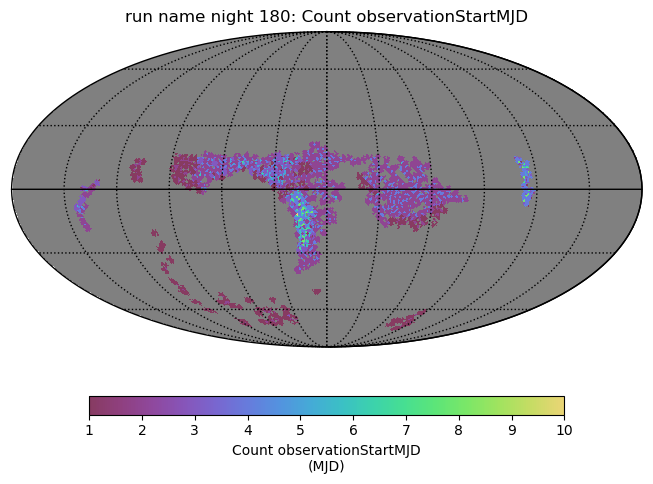

In [21]:
# Similar but for original simulation night 
# (this would be equivalent to part of our comparison for 'survey progress')

metric = maf.CountMetric(col='observationStartMJD')
slicer = maf.HealpixSlicer(nside=64)
constraint = None
bundle = maf.MetricBundle(metric, slicer, constraint, info_label='night 180')

g = maf.MetricBundleGroup({'count': bundle}, None)
g.run_current(sim_data=allobs.to_records(), constraint=None)
ph = maf.PlotHandler()
ph.set_metric_bundles([bundle])
ph.plot(maf.HealpixSkyMap(), plot_dicts={'rot': (180, 0, 0)})